Algorithm

1. initial (manual) marks detection on zero frame
2. calc affin transform matrix for zero frame
3. saving marks and affin transform matrix for zero frame
4. i = 1

-----

5. marks detection on frame[i] using information about frame[i-1]
6. calc affin transform matrix on frame[i] using information about frame[i-1]
7. saving marks and affin transform matrix for frame[i]
8. i++
9. to step 5, until last frame

# Initial detection

In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
from os.path import join as pjoin
from tqdm import tqdm
import os

In [2]:
from utils import golden_section_search, low_clip_value, clip_value, calc_diff, fill_out_circle
from mark_proc import MarkOnImage, create_np_template, detect_mark
from region_detection import detect_region_by_mouse
from video_processing import get_first_frame

In [3]:
from affin_transforms import Affin_Transforms

In [4]:
image_name = 'frame_0.png'
images_dir = 'images'
image_path = pjoin(images_dir, image_name)
videopath = pjoin('..','Test1 - alecsandr27000.mkv')

if not os.path.exists(images_dir):
    os.makedirs(images_dir)
    
image = get_first_frame(framepath=image_path, videopath=videopath)

In [5]:
mark1 = detect_mark(image, *detect_region_by_mouse(image))
mark2 = detect_mark(image, *detect_region_by_mouse(image))
if mark2.x_pos < mark1.x_pos:
    mark1, mark2 = mark2, mark1

In [6]:
aff_tr = Affin_Transforms(mark1, mark2, image.shape)
all_affin_tr = aff_tr.get_all_affin_tr()

In [7]:
prev_mark1 = mark1
prev_mark2 = mark2

In [10]:
video = cv2.VideoCapture(videopath)

In [11]:
total_frames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))

In [12]:
all_affin_transforms_bf = np.zeros((total_frames, 3, 2, 3)) # by frame
mark1_bf = np.zeros((total_frames, len(mark1.get_array_param()))) # by frame
mark2_bf = mark1_bf.copy()

In [13]:
all_affin_transforms_bf[0] = all_affin_tr
mark1_bf[0] = mark1.get_array_param()
mark2_bf[0] = mark2.get_array_param()

# Frame by frame detection

## Detection and transform matrixes computation

In [ ]:
video.release()
video = cv2.VideoCapture(videopath)
_, image = video.read()
k = 0

Сохранение расположений меток на каждом снимке в файлы ```mark.npy```

Сохранение матриц афинный преобразований для каждого кадра в файл ```aff_transforms.npy```

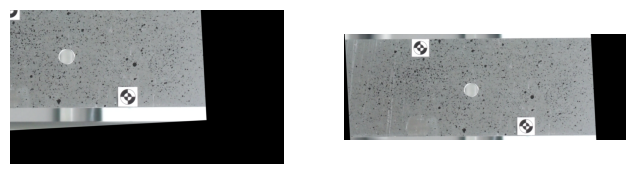

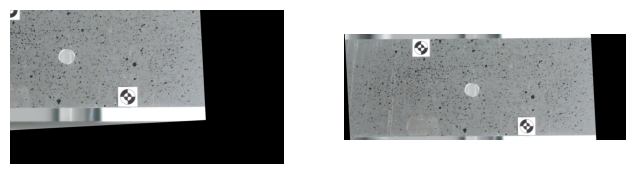

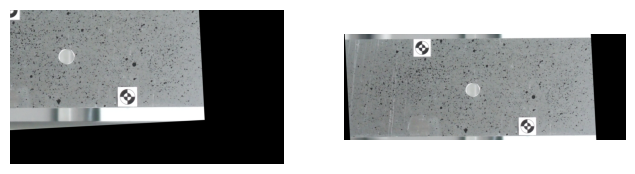

In [29]:
while video.isOpened():
    k += 1
    ret, frame = video.read()
    
    if not ret:
        break

    mark1 = detect_mark(frame, mark1.get_center(), np.ceil(mark1.diam * 0.75).astype(int))
    mark2 = detect_mark(frame, mark2.get_center(), np.ceil(mark2.diam * 0.75).astype(int))

    all_affin_tr = Affin_Transforms(mark1, mark2, frame.shape).get_all_affin_tr()

    all_affin_transforms_bf[k] = all_affin_tr
    mark1_bf[k] = mark1.get_array_param()
    mark2_bf[k] = mark2.get_array_param()

    if k % 40 == 0:
        src = frame.copy()
        warp_algn = cv2.warpAffine(src, all_affin_tr[0], (frame.shape[1], frame.shape[0]))

        _mean_diam = (mark1.diam + mark2.diam) / 2
        (_h, _w) = (src.shape[0], src.shape[1])
        frame_diag = (_h**2 + _w**2)**0.5
        m_dist_x, m_dist_y = (all_affin_tr[0] @ [mark2.x_pos, mark2.y_pos, 1])
        warp_insc = cv2.warpAffine(src, all_affin_tr[1], np.ceil((frame_diag, 2*_mean_diam + m_dist_y)).astype(int))

        fig, ax = plt.subplots(1,2, figsize=(7,2))
        ax[0].axis('off')
        ax[1].axis('off')
        ax[0].imshow(warp_algn)
        ax[1].imshow(warp_insc)

        plt.show()
    
    prev_mark1 = mark1
    prev_mark2 = mark2

## Saving

In [31]:
part_all_affin_transforms_bf = all_affin_transforms_bf[:k]
part_mark1_bf = mark1_bf[:k]
part_mark2_bf = mark2_bf[:k]

In [32]:
np.save('all_affin_transforms.npy', part_all_affin_transforms_bf)
np.save('part_mark1.npy', part_mark1_bf)
np.save('part_mark2.npy', part_mark2_bf)

## Saving videos with applied transforms

In [33]:
algn_video_name = 'algn_video.mp4'
insc_video_name = 'insc_video.mp4'

frame_0 = cv2.imread(image_path)
# Разрешение изображений
frame_width, frame_height = frame_0.shape[1], frame_0.shape[0]

In [34]:
(_h, _w) = (frame_0.shape[0], frame_0.shape[1])
frame_diag = (_h**2 + _w**2)**0.5
_mean_diam = (part_mark1_bf[0][2] + part_mark2_bf[0][2]) / 2
m_dist_x, m_dist_y = (all_affin_tr[0] @ [part_mark2_bf[0][0], part_mark2_bf[0][1], 1])
insc_shape = np.ceil((frame_diag, 2*_mean_diam + m_dist_y)).astype(int)

In [35]:
# Создание объекта VideoWriter
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
algn_video = cv2.VideoWriter(algn_video_name, fourcc, 30.0, (frame_width, frame_height))
insc_video = cv2.VideoWriter(insc_video_name, fourcc, 30.0, insc_shape)

In [36]:
video_in = cv2.VideoCapture(videopath)

In [38]:
# Чтение и запись каждого изображения в видеофайл
for i in range(k):
    
    # Перемещение кадра
    # video_in.set(cv2.CAP_PROP_POS_FRAMES, i)

    ret, frame = video_in.read()

    all_affin_tr = part_all_affin_transforms_bf[i]

    src = frame.copy()
    warp_algn = cv2.warpAffine(src, all_affin_tr[0], (frame_width, frame_height))

    warp_insc = cv2.warpAffine(src, all_affin_tr[1], insc_shape)
    
    algn_video.write(warp_algn)
    insc_video.write(warp_insc)
    

In [39]:
# Закрытие объекта VideoWriter
algn_video.release()
insc_video.release()

In [46]:
min(part_mark2_bf[:,3]),max(part_mark2_bf[:,3])

(2.499873429727545, 2.499873429727545)

In [47]:
min(part_mark1_bf[:,3]),max(part_mark1_bf[:,3])

(2.499873429727545, 3.4997721435562608)